# Автоматическое определение языка текста

In [45]:
import argparse
import codecs
import unicodedata
import operator
import re

import nltk
from nltk import ngrams
import numpy

from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.feature_extraction import DictVectorizer
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt

%matplotlib inline

Будем решать задачу определения языка печатного текста. В файле `europarl.test.txt` содержатся записи депатов в Европарламенте. Каждая строка содержит код языка и высказывание на этом языке, например, на болгарском:

`bg	(DE) Г-н председател, след повече от 300 години колониално управление и след като континентът се превърна в арена на Студената война, днес Латинска Америка вече е един от нововъзникващите региони в света.`

Код языка будет целевой переменной, а из высказывания нам предстоит извлечь признаки.

Один из возможных подходов состоит в том, чтобы в качестве признаков использовать тройки из подряд идущих символов, встречающихся в словах. Предположение состоит в том, что для каждого языка список наиболее популярных троек более-менее уникален. Попробуем проверить это предположение.

## Считывание данных

In [46]:
DS_PATH = "./europarl.test.txt" # Path to the data file
N_GRAM = 3 # Extract symbol sequences of length N
TOP_TOKENS = 10 # Number of top selected n-grams for each language

In [47]:
def read_documents(data_path):
    """
    Reads a sequence of documents from the text file
    located on a given path.

    Returns:
        A generator of tuples (LANG_CODE, unicode)
    """
    with codecs.open(data_path, 'rU', "utf-8") as data_file:
        for line in data_file:
            lang, doc = line.strip().split('\t')
            yield lang, doc

In [48]:
def normalise_document(doc):
    """
    Convert document to lower-case and remove accents
    
    Returns:
        A normalised document as unicode
    """
    return ''.join(c for c in unicodedata.normalize('NFD', doc.lower()) if not unicodedata.combining(c))

In [51]:
def tokenize_document(doc, n):
    """
    Split document in N-Grams
    
    TODO: implement this

    Returns:
        Iterable (generator or list) of unicode n-grams
    """
    tokenizer = nltk.WordPunctTokenizer()
    for token in tokenizer.tokenize(doc):
        if len(token) >= n:
            for ngram in nltk.ngrams(token, n):
                yield u"".join(ngram)

In [53]:
list(tokenize_document("efsafafs", N_GRAM))

[u'efs', u'fsa', u'saf', u'afa', u'faf', u'afs']

Первым делом нам необходимо зачитать данные из файла. Будем читать 3 структуры данных:

- docs - список словарей, каждый из которых соответствует одному документу и содержит количество вхождений для каждой n-граммы (токена)
- langs - список, содержащий классы докуметов (каждому коду языка соответствует числовой класс)
- lang_freq - словарь, который нужен для подсчета ниболее популярных n-грам для каждого языка. Элементы этого словаря: код языка -> (id класса, частоты n-грам (аналогично docs)) 

Для того, чтобы заработал код, зачитывающий данные, необходимо (до) реализовать функции, перечисленные выше.

In [54]:
# A list of dicts, each representing one document in format:
# {token: count1, ...}
docs = []
# Language code for each dict (0-based)
langs = []
# A list of tuples, each tuple corresponds to one language
# First compunent is the code of the language, second is its token frequencies
# Contains entries like {lang_code: (lang_id, {token_frequencies})}
lang_freq = {}

for lang, doc in read_documents(DS_PATH):
    normalized_doc = normalise_document(doc)

    token_freq = {}
    for token in tokenize_document(normalized_doc, N_GRAM):
        token_freq[token] = 1 + token_freq.get(token, 0)
        if lang not in lang_freq:
            print "Found language %s: %d" % (lang, len(lang_freq))
            lang_freq[lang] = (len(lang_freq), {})
        lang_freq[lang][1][token] = 1 + lang_freq[lang][1].get(token, 0)

    docs.append(token_freq)
    langs.append(lang_freq[lang][0])

Found language bg: 0
Found language cs: 1
Found language da: 2
Found language de: 3
Found language el: 4
Found language en: 5
Found language es: 6
Found language et: 7
Found language fi: 8
Found language fr: 9
Found language hu: 10
Found language it: 11
Found language lt: 12
Found language lv: 13
Found language nl: 14
Found language pl: 15
Found language pt: 16
Found language ro: 17
Found language sk: 18
Found language sl: 19
Found language sv: 20


In [56]:
docs[:10]

[{u'020': 1,
  u'202': 1,
  u'\u0430\u0440\u0430': 1,
  u'\u0430\u0440\u0442': 1,
  u'\u0430\u0442\u0438': 1,
  u'\u0430\u0442\u043e': 1,
  u'\u0430\u0446\u0438': 1,
  u'\u0431\u0432\u0430': 1,
  u'\u0432\u0430\u0442': 1,
  u'\u0432\u0440\u043e': 1,
  u'\u0435\u0432\u0440': 1,
  u'\u0435\u043d\u0442': 1,
  u'\u0437\u0430\u0446': 1,
  u'\u0437\u0445\u043e': 1,
  u'\u0438\u0432\u0430': 1,
  u'\u0438\u0437\u0430': 1,
  u'\u0438\u0437\u0445': 1,
  u'\u0438\u0440\u0430': 1,
  u'\u043a\u043e\u043d': 1,
  u'\u043a\u0443\u0440': 1,
  u'\u043c\u0430\u0440': 1,
  u'\u043d\u043a\u0443': 1,
  u'\u043d\u043e\u0432': 1,
  u'\u043d\u0442\u0435': 1,
  u'\u043e\u043d\u043a': 1,
  u'\u043e\u043f\u0430': 1,
  u'\u043f\u0440\u0438': 1,
  u'\u0440\u0430\u0442': 1,
  u'\u0440\u0435\u043d': 1,
  u'\u0440\u0438\u0432': 1,
  u'\u0440\u043e\u043f': 1,
  u'\u0440\u0442\u0438': 1,
  u'\u0440\u044f\u0431': 1,
  u'\u0441\u0442\u0430': 1,
  u'\u0442\u0430\u0440': 1,
  u'\u0442\u0435\u043d': 1,
  u'\u0442\u0438\u0437

In [60]:
langs[-10:]

[20, 20, 20, 20, 20, 20, 20, 20, 20, 20]

In [65]:
print lang_freq['el']

(4, {u'\u03c7\u03b1\u03c4': 3, u'\u03be\u03b9\u03bd': 1, u'sco': 1, u'\u03b3\u03b9\u03b1': 541, u'\u03b3\u03b9\u03b6': 1, u'\u03b3\u03b9\u03b5': 19, u'\u03b3\u03b9\u03ba': 67, u'\u03b3\u03b9\u03bf': 5, u'\u03b3\u03b9\u03bd': 44, u'\u03bf\u03b3\u03c9': 29, u'aub': 1, u'aue': 1, u'\u03bc\u03b9\u03c3': 54, u'\u03bf\u03b3\u03c1': 43, u'aul': 1, u'\u03b4\u03b7\u03c1': 5, u'\u03b1\u03be\u03b5': 20, u'mwa': 1, u'\u03b1\u03be\u03b7': 26, u'\u03b1\u03be\u03b1': 1, u'\u03b1\u03be\u03bf': 4, u'\u03b1\u03be\u03b9': 50, u'\u03b1\u03be\u03c5': 33, u'\u03c0\u03b7\u03c7': 2, u'\u03c0\u03b7\u03c4': 4, u'\u03bf\u03b3\u03b9': 100, u'\u03bc\u03b9\u03b5': 8, u'\u03bc\u03b9\u03b6': 14, u'\u03bf\u03b3\u03bd': 4, u'\u03bc\u03b9\u03b1': 253, u'\u03bf\u03b3\u03bf': 54, u'\u03bc\u03b9\u03b3': 2, u'\u03bf\u03b3\u03b1': 6, u'\u03bf\u03c7\u03c9': 9, u'\u03bc\u03b9\u03bf': 38, u'\u03bf\u03b3\u03b5': 17, u'\u03bc\u03b9\u03ba': 125, u'\u03bc\u03b9\u03bb': 26, u'\u03b3\u03b9\u03c3': 41, u'upl': 1, u'\u03b3\u03b9\u03c9'

## Отбор признаков

Здесь предстоит выбрать топовые n-граммы для каждого языка (`select_features`) и отфильтровать документы так, чтобы в них остались только отобранные (`keep_only_features`)

In [78]:
def select_features(lang_freq, top_tokens):
    """
    From each language selects top_tokens to be used as features
    
    TODO: Implement this

    Returns:
        set(unicode tokens)
    """
    features = set()
    for lang, (lid, token_freq) in lang_freq.iteritems():
        sorted_token_freq = sorted(token_freq.iteritems(), key=operator.itemgetter(1), reverse=True)
        for token, freq in sorted_token_freq[:top_tokens]:
            features.add(token)
    return features

In [79]:
list(select_features(lang_freq, TOP_TOKENS))

[u'sch',
 u'ali',
 u'sza',
 u'ost',
 u'sze',
 u'\u03b3\u03b9\u03b1',
 u'tta',
 u'lle',
 u'ist',
 u'ima',
 u'och',
 u'ver',
 u'ell',
 u'\u0440\u0435\u0434',
 u'ies',
 u'tin',
 u'ele',
 u'iem',
 u'ien',
 u'tai',
 u'hat',
 u'\u043f\u0440\u0435',
 u'\u03b1\u03c0\u03bf',
 u'owa',
 u'sel',
 u'ere',
 u'ich',
 u'one',
 u'ssa',
 u'gen',
 u'eme',
 u'and',
 u'die',
 u'\u03c4\u03c9\u03bd',
 u'een',
 u'\u03c0\u03c1\u03bf',
 u'nje',
 u'cio',
 u'ija',
 u'are',
 u'sen',
 u'ter',
 u'\u043d\u0438\u0435',
 u'\u03c4\u03b7\u03c2',
 u'est',
 u'\u03c4\u03b9\u03ba',
 u'\u03ba\u03b1\u03b9',
 u'res',
 u'ese',
 u'ych',
 u'del',
 u'nes',
 u'red',
 u'meg',
 u'men',
 u'\u0430\u0442\u0430',
 u'ast',
 u'ntr',
 u'les',
 u'que',
 u'nte',
 u'ate',
 u'ace',
 u'dzi',
 u'aci',
 u'nde',
 u'ati',
 u'att',
 u'und',
 u'ung',
 u'com',
 u'ise',
 u'con',
 u'pre',
 u'wie',
 u'\u0438\u0442\u0435',
 u'som',
 u'\u03c4\u03b7\u03bd',
 u'ons',
 u'pod',
 u'het',
 u'use',
 u'van',
 u'che',
 u'tor',
 u'usi',
 u'ust',
 u'cht',
 u'zio',
 u'o

In [80]:
def keep_only_features(docs, features):
    """
    Removes non-feature tokens from the document representations
    """
    for token_freq in docs:
        for token in token_freq.keys():
            if token not in features:
                del token_freq[token]

In [82]:
# Select top n features for each lang
features = select_features(lang_freq, TOP_TOKENS)
# Remove from documents all features except the selected
keep_only_features(docs, features)

# Transform documents to numpy matrix
dv = DictVectorizer()
x = dv.fit_transform(docs).todense()
y = numpy.array(langs)
print "Data set shape x=(%d x %d) y=%d" % (x.shape[0], x.shape[1], len(y))

Data set shape x=(21000 x 151) y=21000


In [84]:
list(features)[:10]

[u'sch',
 u'ali',
 u'sza',
 u'ost',
 u'sze',
 u'\u03b3\u03b9\u03b1',
 u'tta',
 u'lle',
 u'ist',
 u'ima']

In [91]:
dv.feature_names_

[u'aan',
 u'ace',
 u'aci',
 u'ais',
 u'ali',
 u'and',
 u'ani',
 u'anj',
 u'are',
 u'ast',
 u'ate',
 u'ati',
 u'att',
 u'cao',
 u'che',
 u'cht',
 u'cio',
 u'com',
 u'con',
 u'del',
 u'den',
 u'der',
 u'det',
 u'die',
 u'dzi',
 u'een',
 u'ega',
 u'ego',
 u'egy',
 u'eik',
 u'ein',
 u'ele',
 u'ell',
 u'eme',
 u'end',
 u'eni',
 u'ent',
 u'ere',
 u'ese',
 u'est',
 u'ete',
 u'ett',
 u'for',
 u'gen',
 u'hat',
 u'het',
 u'hog',
 u'iba',
 u'ich',
 u'iem',
 u'ien',
 u'ies',
 u'ija',
 u'ima',
 u'ina',
 u'ing',
 u'ini',
 u'int',
 u'ion',
 u'ise',
 u'ist',
 u'jum',
 u'kad',
 u'kto',
 u'les',
 u'lig',
 u'lle',
 u'meg',
 u'men',
 u'mis',
 u'nde',
 u'nes',
 u'nia',
 u'nie',
 u'nje',
 u'nte',
 u'ntr',
 u'och',
 u'ogy',
 u'one',
 u'ons',
 u'oor',
 u'ost',
 u'ova',
 u'owa',
 u'par',
 u'pie',
 u'pod',
 u'pra',
 u'pre',
 u'pri',
 u'pro',
 u'prz',
 u'que',
 u'rav',
 u'red',
 u'res',
 u'rze',
 u'sch',
 u'sel',
 u'sen',
 u'som',
 u'ssa',
 u'sta',
 u'ste',
 u'sza',
 u'sze',
 u'taa',
 u'tai',
 u'tat',
 u'ter',
 

## Создание и настройка модели

В этом пункте требуется реализовать модель (NB) и оценить метрику `accuracy` на кросс-валидации.

In [10]:
from sklearn.base import BaseEstimator, ClusterMixin

class MNB(BaseEstimator, ClusterMixin): 
    
    def __init__(self):
        """
        Инициализация метода
        """
        pass

    def fit(self, X, y=None):
        """
        Процедура обучения
        """
        
        ## Your Code Here
        # ...
        
        return self

    def predict(self, X, y=None):
        """
        Процедура предсказания класса
        
        """
        return np.random.rand(X.shape[0], 1)
    

def create_model():
    """
    Initialise an NB model, supported by Sklearn

    Returns:
        Sklearn model instance
    """
    return MNB()

In [11]:
def validate_model(model, x, y, folds=10):
    """
    Computes cross-validation score for the given data set and model.
    
    TODO: Implement this

    Returns:
        A numpy.array of accuracy scores.
    """
    return [0.9, 0.9, 0.8]

In [12]:
def plot_roc(model, x, y, class_ind=0):    
    # Compute ROC curve
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.5, random_state=0)
    fit = model.fit(x_train, y_train)
    y_prob = fit.predict_proba(x_test)    
    fpr, tpr, _ = roc_curve(y_test, y_prob[:, class_ind], pos_label=class_ind)
    roc_auc = auc(fpr, tpr)
    # Plot ROC curve
    plt.fill_between(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, alpha=0.3)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for class index %s' % class_ind)

_Замечание_ : обратите внимание, что тут нужно реализовать перебор параметров.

In [13]:
# TODO: Implement parameter grid search here
model = create_model()
# Print cross-validated accturacy
scores = validate_model(model, x, y)
print "Model mean accuracy: {}".format(numpy.mean(scores))

# Plot ROC
plt.figure(figsize=(8, 8))
plot_roc(model, x, y, 1)
plt.show()

Model mean accuracy: 0.866666666667


AttributeError: 'MNB' object has no attribute 'predict_proba'

## Создание и настройка модели

В этом пункте требуется реализовать модель (NB) и перебрать различные значения параметров. Предлагается попробовать Multinumial и Bernoulli варианты из sklearn и несколько значений параметров (alpha, binarize, fit_prior) и выбрать наилучшую модель на основании метрики `accuracy`, полученной на кросс-валидации.

In [14]:
def create_model():
    """
    Initialise an NB model, supported by Sklearn

    Returns:
        Sklearn model instance
    """
    return MultinomialNB()

Model mean accuracy: 0.866666666667


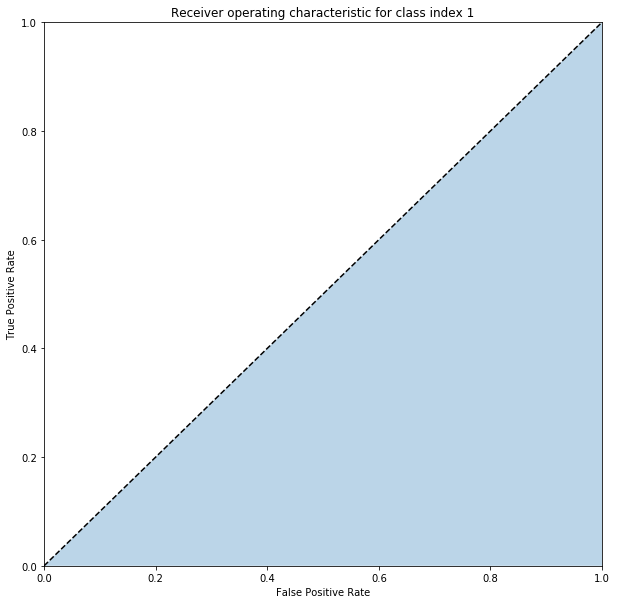

In [15]:
model = create_model()
# Print cross-validated accturacy
scores = validate_model(model, x, y)
print "Model mean accuracy: {}".format(numpy.mean(scores))

# Plot ROC
plt.figure(figsize=(10, 10))
plot_roc(model, x, y, 1)
plt.show()

## Дополнительно

- Выясните, какие классы чаще всего путаются (на кросс-валидации!)
- Сравните NB и KNN